In [46]:
import numpy as np
import pandas as pd
from copulas.multivariate import GaussianMultivariate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from scipy.stats import anderson
import matplotlib.pyplot as plt
import joblib

In [47]:
dir = 'C:/Users/fitzpatrick/Desktop/Data/Input/'
lake = ['MiHur','Erie','Ont','Sup']

In [56]:
# P, E, R are read in from a csv I created for easy use
data_1 = pd.read_csv(dir+lake[1]+'_dataset_6mo_cms.csv',sep=',')
data_1['Date'] = pd.to_datetime(data_1['Date'])
data_1['Month'] = data_1['Date'].dt.month

# NBS from L2SWBM for each lake
data_2 = pd.read_csv(dir+lake[1]+'_l2swbm_nbs.csv',sep=',')
data_2['Date'] = pd.to_datetime(data_2['Date'])
data_2.set_index('Date', inplace=True)

# Merge them into one dataframe to align the timeframes
df = data_1.merge(data_2, on='Date')
df.head()

,Date,R(m),P(m),E(m),R(m-1),P(m-1),E(m-1),R(m-2),P(m-2),E(m-2),...,P(m-5),E(m-5),R(m-6),P(m-6),E(m-6),Month,NBS(m),NBS(m-1),NBS(m-2),NBS(m-3)
0,1979-07-01,270.147413,838.679304,447.521306,325.820659,799.979063,289.695399,524.612246,1229.248943,199.110481,...,688.470282,396.122241,0.000000,1054.201890,456.765696,7,48.9967,79.0767,152.4003,278.7354
1,1979-08-01,273.041284,862.776304,581.730925,270.147413,838.679304,447.521306,325.820659,799.979063,289.695399,...,1088.281147,82.955132,369.239992,688.470282,396.122241,8,29.2268,48.9967,79.0767,152.4003
2,1979-09-01,485.873656,651.082724,562.513794,273.041284,862.776304,581.730925,270.147413,838.679304,447.521306,...,1655.896637,145.850495,652.335147,1088.281147,82.955132,9,-13.9793,29.2268,48.9967,79.0767
3,1979-10-01,338.298057,752.020394,609.128485,485.873656,651.082724,562.513794,273.041284,862.776304,581.730925,...,1229.248943,199.110481,1275.329971,1655.896637,145.850495,10,-61.0342,-13.9793,29.2268,48.9967
4,1979-11-01,485.438656,1342.701253,405.993138,338.298057,752.020394,609.128485,485.873656,651.082724,562.513794,...,799.979063,289.695399,524.612246,1229.248943,199.110481,11,41.2668,-61.0342,-13.9793,29.2268


In [57]:
# Shift the water level so the model is training on using the previous month's water level
#historical_data['Previous_Month_Water_Level'] = historical_data['Water_Level'].shift(1)
# Drop the first line of data since previous_month_water_level is now nan
#historical_data = historical_data.dropna()

# Extract features (precipitation, evaporation, runoff, water levels, and month) and target (net basin supply) from historical data
features = df[['P(m)', 'E(m)', 'R(m)', 'Date',]] #'Previous_Month_Water_Levels']]
features['Month'] = pd.to_datetime(features['Date']).dt.month  # Extract month from date
features = features.drop(columns=['Date'])

target = df['NBS(m)']

print(features, target)

            P(m)         E(m)        R(m)  Month
0     838.679304   447.521306  270.147413      7
1     862.776304   581.730925  273.041284      8
2     651.082724   562.513794  485.873656      9
3     752.020394   609.128485  338.298057     10
4    1342.701253   405.993138  485.438656     11
..           ...          ...         ...    ...
493   551.097063   831.246566  189.059673      8
494   395.970038  1060.993510  294.486327      9
495   898.734697  1028.411584  280.563542     10
496   925.980868   797.486195  388.672991     11
497   961.216488   604.988748  636.809018     12

[498 rows x 4 columns] 0      48.9967
1      29.2268
2     -13.9793
3     -61.0342
4      41.2668
        ...   
493   -39.4783
494   -92.2995
495   -36.1725
496   -45.7464
497    30.5666
Name: NBS(m), Length: 498, dtype: float64


C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_8\2333850927.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Month'] = pd.to_datetime(features['Date']).dt.month  # Extract month from date


In [58]:
# Scaling features and target variable
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1)).flatten()

# One-hot encode month feature
month_encoder = OneHotEncoder()
month_encoded = month_encoder.fit_transform(features[['Month']])
features_scaled = np.concatenate([features_scaled, month_encoded.toarray()], axis=1)


In [59]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Fitting copula model on training data
copula = GaussianMultivariate()
copula.fit(X_train)

c:\Users\fitzpatrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\fitzpatrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\fitzpatrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\fitzpatrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\fitzpatrick\AppData\Local\Programs\Python\Python312\Lib\site-packag

In [60]:
# Generate synthetic samples for all variables (including the target) using the fitted copula model
synthetic_samples = copula.sample(X_test.shape[0])

In [61]:
# Convert synthetic_samples DataFrame to a NumPy array
synthetic_samples_array = synthetic_samples.to_numpy()

# Extract the synthetic target variable (last column of synthetic_samples_array)
synthetic_samples_target = synthetic_samples_array[:, -1]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, synthetic_samples_target)

print("Mean Absolute Error (MAE) between synthetic samples and actual test data:", mae)

Mean Absolute Error (MAE) between synthetic samples and actual test data: 0.4774039623228728


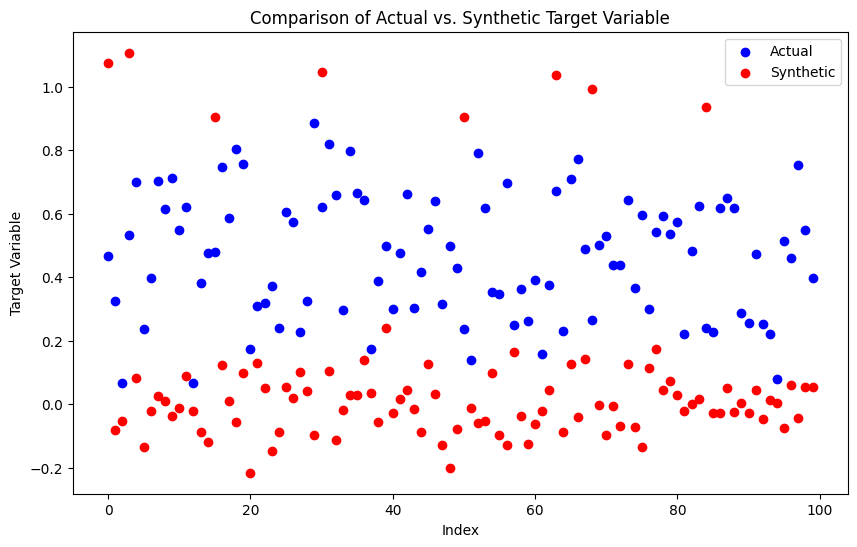

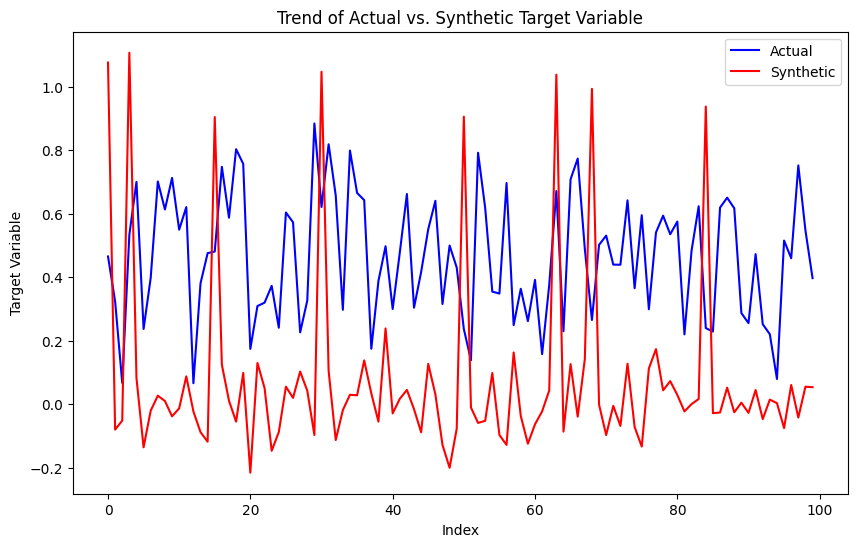

In [62]:
import matplotlib.pyplot as plt

# Create a scatter plot to compare actual vs. synthetic target variable
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(synthetic_samples_target)), synthetic_samples_target, color='red', label='Synthetic')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.title('Comparison of Actual vs. Synthetic Target Variable')
plt.legend()
plt.show()

# Create a line plot to visualize the trend of actual vs. synthetic target variable
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(synthetic_samples_target)), synthetic_samples_target, color='red', label='Synthetic')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.title('Trend of Actual vs. Synthetic Target Variable')
plt.legend()
plt.show()

In [ ]:
## This section has not been tested yet.

# Load the trained copula model for net basin supply prediction
copula_model = joblib.load('copula_model_net_basin_supply.pkl')

# Prepare forecasted data
forecasted_runoff = pd.read_csv('forecasted_runoff.csv')  # Assuming your forecasted runoff data is stored in a CSV file
forecasted_precipitation = pd.read_csv('forecasted_precipitation.csv')  # Assuming your forecasted precipitation data is stored in a CSV file
forecasted_evaporation = pd.read_csv('forecasted_evaporation.csv')  # Assuming your forecasted evaporation data is stored in a CSV file
last_month_water_level = pd.read_csv('last_month_water_level.csv')['water_level'].values[0]  # Assuming your last month water level data is stored in a CSV file

# Concatenate the forecasted data into a single DataFrame
forecasted_data = pd.concat([forecasted_runoff, forecasted_precipitation, forecasted_evaporation, last_month_water_level], axis=1)

# Extract features from the forecasted data
features = forecasted_data[['precipitation', 'evaporation', 'runoff', 'water_levels', 'month']]

# One-hot encode month feature
month_encoder = OneHotEncoder()
month_encoded = month_encoder.fit_transform(features[['month']])
features.drop(columns=['month'], inplace=True)

# Concatenate encoded month feature with other features
features = np.concatenate([features.values, month_encoded.toarray()], axis=1)

# Normalize features
scaler_features = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)

# Predict net basin supply for the next month
predicted_net_basin_supply_normalized = copula_model.predict(features_normalized)

# Inverse transform the predicted net basin supply to obtain the original scale
scaler_target = copula_model.named_steps['copula'].marginal_distributions_['net_basin_supply']
predicted_net_basin_supply = scaler_target.inverse_transform(predicted_net_basin_supply_normalized.reshape(-1, 1))

# Create a DataFrame to store the predicted net basin supply
predicted_net_basin_supply_df = pd.DataFrame(predicted_net_basin_supply, columns=['predicted_net_basin_supply'])

print("Predicted net basin supply for the next month:")
print(predicted_net_basin_supply_df)